# Model Evaluation and Hyperparameter Tuning

>**TODO** 
> - Completare la parte sulle pipelines introducendo esempio di Lewinson
> - Introdurre anche esempi sulla regressione logistica con credito

In the previous chapters, you learned about the essential machine learning algorithms for classification and how to get our data into shape before we feed it into those algorithms. Now, it's time to learn about the best practices of building good machine learning models by fine-tuning the algorithms and evaluating the performance of the models. In this chapter, we will learn how to do the following:
- Assess the performance of machine learning models
- Diagnose the common problems of machine learning algorithms
- Fine-tune machine learning models
- Evaluate predictive models using different performance metrics

## Combining Transformers and Estimators in a Pipeline

### Let's make a simple project from scratch ...

In this chapter, we tackle a binary classification problem set in the financial industry. We
work with a dataset contributed to the UCI Machine Learning Repository (a very popular
data repository). The dataset used in this chapter was collected in a Taiwanese bank in October 2005. The
study was motivated by the fact that—at that time—more and more banks were giving cash
(and credit card) credit to willing customers. You can download the sample file [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

In [27]:
import pandas as pd

if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [29]:
column_dtypes = {'EDUCATION': 'category',
'MARRIAGE': 'category',
'SEX': 'category',
'PAYMENT_STATUS_SEP': 'category',
'PAYMENT_STATUS_AUG': 'category',
'PAYMENT_STATUS_JUL': 'category',
'PAYMENT_STATUS_JUN': 'category',
'PAYMENT_STATUS_MAY': 'category',
'PAYMENT_STATUS_APR': 'category'}

df = pd.read_csv(path + 'credit_card_default.csv', index_col=0, na_values='', dtype=column_dtypes, sep=',')
df.head()

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [32]:
X = df.copy()
y = X.pop('default_payment_next_month')

In [33]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
age,29850.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
bill_statement_sep,30000.0,51223.33,73635.86,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_statement_aug,30000.0,49179.08,71173.77,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_statement_jul,30000.0,47013.15,69349.39,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_statement_jun,30000.0,43262.95,64332.86,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_statement_may,30000.0,40311.40,60797.16,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_statement_apr,30000.0,38871.76,59554.11,-339603.0,1256.00,17071.0,49198.25,961664.0
previous_payment_sep,30000.0,5663.58,16563.28,0.0,1000.00,2100.0,5006.00,873552.0
previous_payment_aug,30000.0,5921.16,23040.87,0.0,833.00,2009.0,5000.00,1684259.0


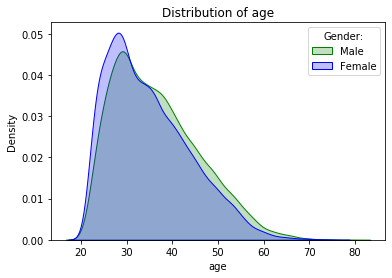

In [39]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots()
sns.distplot(df.loc[df.sex=='Male', 'age'].dropna(),
    hist=False, color='green',
    kde_kws={"shade": True},
    ax=ax, label='Male')
sns.distplot(df.loc[df.sex=='Female', 'age'].dropna(),
    hist=False, color='blue',
    kde_kws={"shade": True},
ax=ax, label='Female')
ax.set_title('Distribution of age')
ax.legend(title='Gender:')

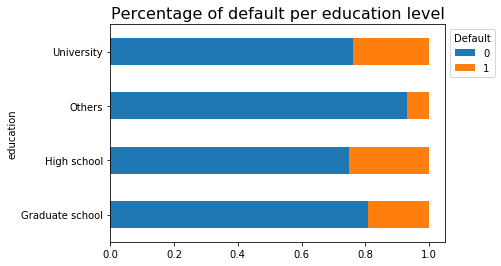

In [40]:
ax = df.groupby("education")['default_payment_next_month'] \
.value_counts(normalize=True) \
.unstack() \
.plot(kind='barh', stacked='True')
ax.set_title('Percentage of default per education level',
fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1))

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [45]:
import missingno
from sklearn.impute import SimpleImputer

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             30000 non-null  int64  
 1   sex                   29850 non-null  object 
 2   education             29850 non-null  object 
 3   marriage              29850 non-null  object 
 4   age                   29850 non-null  float64
 5   payment_status_sep    30000 non-null  object 
 6   payment_status_aug    30000 non-null  object 
 7   payment_status_jul    30000 non-null  object 
 8   payment_status_jun    30000 non-null  object 
 9   payment_status_may    30000 non-null  object 
 10  payment_status_apr    30000 non-null  object 
 11  bill_statement_sep    30000 non-null  int64  
 12  bill_statement_aug    30000 non-null  int64  
 13  bill_statement_jul    30000 non-null  int64  
 14  bill_statement_jun    30000 non-null  int64  
 15  bill_statement_may 

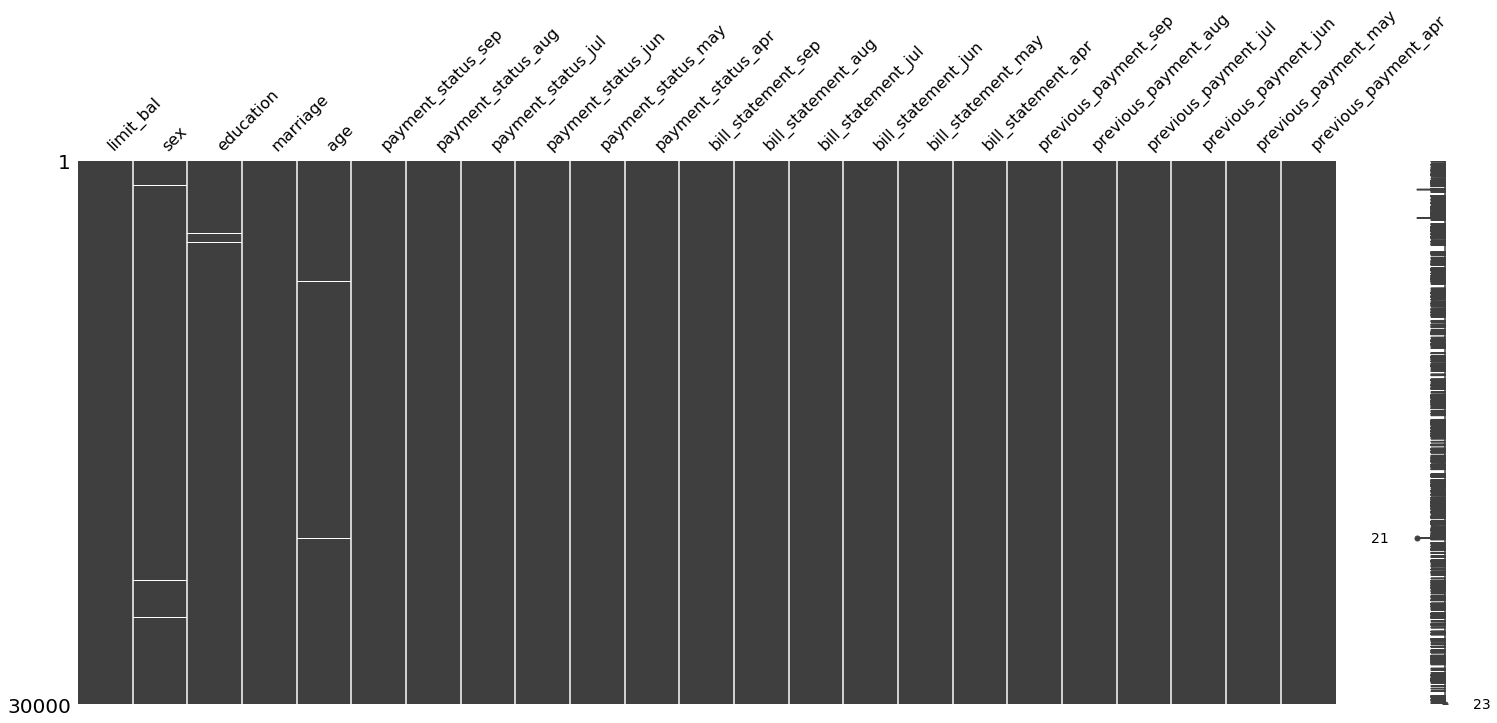

In [46]:
missingno.matrix(X)

In [47]:
NUM_FEATURES = ['age']
CAT_FEATURES = ['sex', 'education', 'marriage']

In [48]:
for col in NUM_FEATURES:
    num_imputer = SimpleImputer(strategy='median')
    num_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = num_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = num_imputer.transform(X_test[[col]])

In [49]:
for col in CAT_FEATURES:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = cat_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = cat_imputer.transform(X_test[[col]])

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 21753 to 23654
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             24000 non-null  int64  
 1   sex                   24000 non-null  object 
 2   education             24000 non-null  object 
 3   marriage              24000 non-null  object 
 4   age                   24000 non-null  float64
 5   payment_status_sep    24000 non-null  object 
 6   payment_status_aug    24000 non-null  object 
 7   payment_status_jul    24000 non-null  object 
 8   payment_status_jun    24000 non-null  object 
 9   payment_status_may    24000 non-null  object 
 10  payment_status_apr    24000 non-null  object 
 11  bill_statement_sep    24000 non-null  int64  
 12  bill_statement_aug    24000 non-null  int64  
 13  bill_statement_jul    24000 non-null  int64  
 14  bill_statement_jun    24000 non-null  int64  
 15  bill_statement_

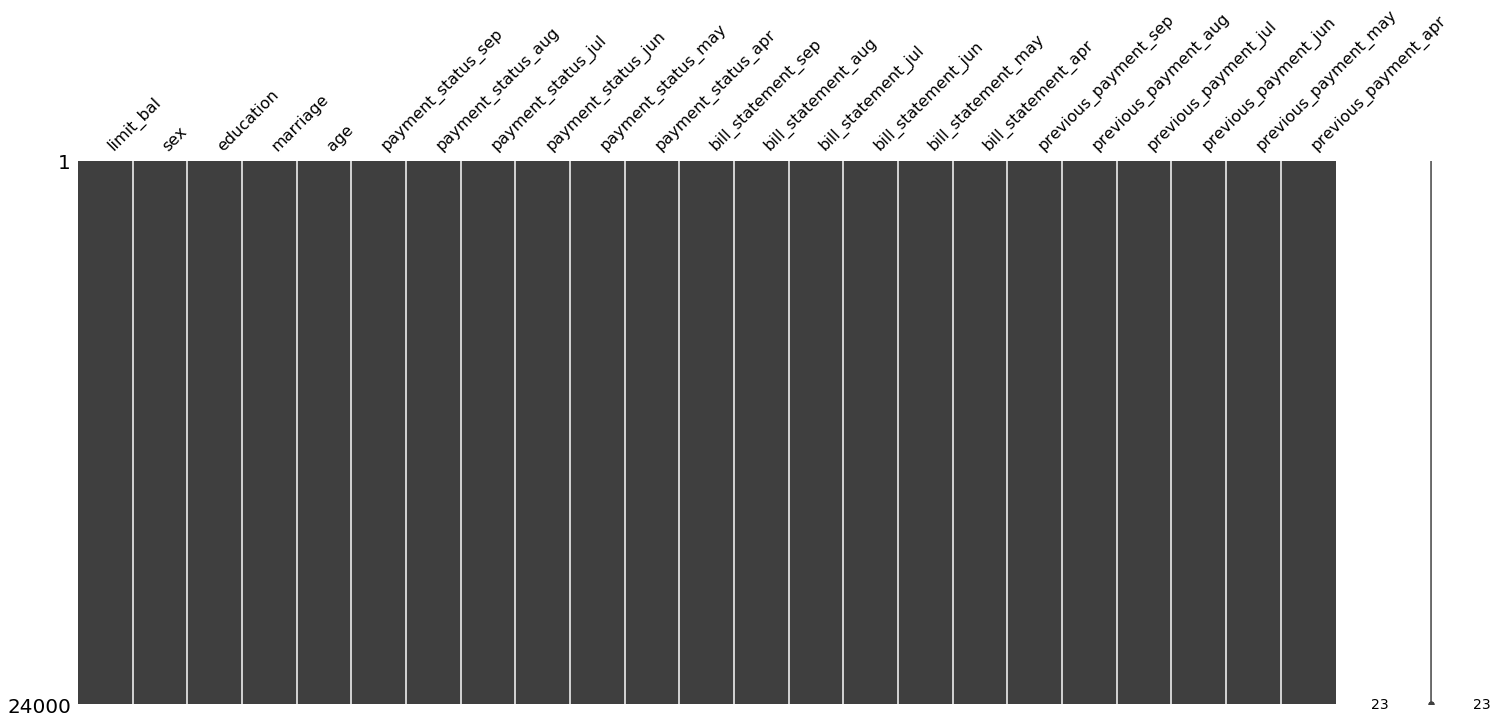

In [52]:
missingno.matrix(X_train)

### Now Use a Pipeline

The make_pipeline function takes an arbitrary number of scikit-learn transformers (objects that support the fit and transform methods as input), followed by a scikit- learn estimator that implements the fit and predict methods.

We can think of a scikit-learn Pipeline as a meta-estimator or wrapper around those individual transformers and estimators. If we call the fit method of Pipeline, the data will be passed down a series of transformers via fit and transform calls
on these intermediate steps until it arrives at the estimator object (the final element
in a pipeline). The estimator will then be fitted to the transformed training data. 

The make_pipeline function takes an arbitrary number of scikit-learn transformers
(objects that support the fit and transform methods as input), followed by a scikitlearn
estimator that implements the fit and predict methods.

## Model Performance and Cross-Validation 

One of the key steps in building a machine learning model is to estimate its
performance on data that the model hasn't seen before. Let's assume that we fit our
model on a training dataset and use the same data to estimate how well it performs on
new data. 

We remember from that a model can suffer from
**underfitting (high bias)** if the model is too simple, or it can **overfit** the training data
**(high variance)** if the model is too complex for the underlying training data.
To find an acceptable *bias-variance tradeoff*, we need to evaluate our model
carefully. In this section, you will learn about the common **cross-validation**
techniques holdout cross-validation and k-fold cross-validation, which can help
us to obtain reliable estimates of the model's generalization performance, that is,
how well the model performs on unseen data.

### Holdout Method

Using the holdout method, we
split our initial dataset into separate training and test datasets—the former is used
for model training, and the latter is used to estimate its generalization performance.
However, in typical machine learning applications, we are also interested in tuning
and comparing different parameter settings to further improve the performance for
making predictions on unseen data. This process is called model selection, with
the name referring to a given classification problem for which we want to select
the optimal values of tuning parameters (also called hyperparameters). However, if
we reuse the same test dataset over and over again during model selection, it will
become part of our training data and thus the model will be more likely to overfit.

A better way of using the holdout method for model selection is to separate the
data into three parts: a training dataset, a validation dataset, and a test dataset.
The training dataset is used to fit the different models, and the performance on the
validation dataset is then used for the model selection. The advantage of having
a test dataset that the model hasn't seen before during the training and model
selection steps is that we can obtain a less biased estimate of its ability to generalize
to new data. The following figure illustrates the concept of holdout cross-validation,
where we use a validation dataset to repeatedly evaluate the performance of the
model after training using different hyperparameter values. Once we are satisfied
with the tuning of hyperparameter values, we estimate the model's generalization
performance on the test dataset:

![chapter-4-5_pic_0.png](./pic/chapter-4-5_pic_0.png)
*From S. Raschka et al. (see Reference)*

### k-fold Cross-Validation

In k-fold cross-validation, we randomly split the training dataset into k folds without
replacement, where k – 1 folds are used for the model training, and one fold is used
for performance evaluation. This procedure is repeated k times so that we obtain k
models and performance estimates.

We then calculate the average performance of the models based on the different,
independent test folds to obtain a performance estimate that is less sensitive
to the sub-partitioning of the training data compared to the holdout method.
Typically, we use k-fold cross-validation for model tuning, that is, finding the
optimal hyperparameter values that yield a satisfying generalization performance,
which is estimated from evaluating the model performance on the test folds.
Once we have found satisfactory hyperparameter values, we can retrain the model
on the complete training dataset and obtain a final performance estimate using the
independent test dataset. The rationale behind fitting a model to the whole training
dataset after k-fold cross-validation is that providing more training examples to
a learning algorithm usually results in a more accurate and robust model.

![chapter-4-5_pic_1.png](./pic/chapter-4-5_pic_1.png)
*From S. Raschka et al. (see Reference)*

## Validation Curves

## Tuning hyperparameters via grid search

# References

*Eryk Lewinson*, "**Python For Finance Cookbook**",  Packt Publishing (2020)

*Sebastian Raschka and Vahid Mirjalili* "**Machine Learning with Python**", 3rd edition, Packt Publishing